In [1]:
from glob import glob
import os as os
import matplotlib.pyplot as plt  
import matplotlib as mpl  
import numpy as np  
import pandas as pd
import scipy as scipy

import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

from scipy.ndimage.morphology import binary_fill_holes, binary_closing, binary_dilation  

plt.rcParams['figure.figsize'] = (10, 6)  

Using TensorFlow backend.


In [2]:
subject_annotations = pd.read_table('subject_annotations.txt')
sample_annotations = pd.read_table('sample_annotations.txt')

sample_id_list = sample_annotations['SAMPID']
sample_id_dict = {}

# Create dictionary of slide names and corresponding index in sample annotations txt
for i in range(0, len(sample_id_list)):
    sample_id = sample_id_list[i]
    sample_id_shortened = sample_id[0:sample_id.rfind("-", 0, sample_id.rfind("-"))]
    sample_id_dict[sample_id_shortened] = i

In [3]:
def generate_tile_img_matrix(data_type, slide_type):
    '''
    Iterates through tiles and returns:
    1. NdArray of image matrices 
    2. Array of scores corresponding to tile image
    '''
    read_slides_path = "data/" + data_type + "/" + slide_type + "s/"
    tiles = glob(read_slides_path + "*.png")    
    
    img_matrix_array = []
    scores_array = np.array([])
    
    for tile in tiles:
        
        # append image matrix
        tile_data = scipy.misc.imread(tile)
        img_matrix_array.append(tile_data)
        
        # read slide name from tile [slide_name]_[slide_index].png score value
        slide_name = tile[tile.rfind('/')+1:tile.rfind('_')]
        row_index = sample_id_dict[slide_name]
        # get Intragenic Rate: The fraction of reads that map within genes (within introns or exons)
        SMNTRART = sample_annotations.iloc[[row_index]]['SMNTRART'].values[0]
        row = np.array([SMNTRART])
        scores_array = np.concatenate((scores_array, row))
    
    return img_matrix_array, scores_array

In [4]:
# generate image matrices for each slide and data type
liver_test_data, liver_test_labels = generate_tile_img_matrix("validation", "liver")
lung_test_data, lung_test_labels = generate_tile_img_matrix("validation", "lung")
liver_train_data, liver_train_labels = generate_tile_img_matrix("train", "liver")
lung_train_data, lung_train_labels = generate_tile_img_matrix("train", "lung")

In [5]:
# sanity check
liver_test_data = np.asarray(liver_test_data)
lung_test_data = np.asarray(lung_test_data)
print(liver_test_data.shape)
print(liver_test_labels.shape)
print(lung_test_data.shape)
print(lung_test_labels.shape)

liver_train_data = np.asarray(liver_train_data)
lung_train_data = np.asarray(lung_train_data)
print(liver_train_data.shape)
print(liver_train_labels.shape)
print(lung_train_data.shape)
print(lung_train_labels.shape)

(541, 128, 128, 3)
(541,)
(837, 128, 128, 3)
(837,)
(2221, 128, 128, 3)
(2221,)
(3133, 128, 128, 3)
(3133,)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [7]:
# generate train data
x_train = np.concatenate((lung_train_data, liver_train_data))
y_train = np.concatenate((lung_train_labels, liver_train_labels))

for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=x_train.shape[0]):
    x_train = x_batch
    y_train = y_batch
    break 

In [8]:
# generate test data
x_test = np.concatenate((lung_test_data, liver_test_data))
y_test = np.concatenate((lung_test_labels, liver_test_labels))

for x_batch, y_batch in train_datagen.flow(x_test, y_test, batch_size=x_test.shape[0]):
    x_test = x_batch
    y_test = y_batch
    break 

In [1]:
# dimensions of our images.
img_width, img_height = 128, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

def base_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model 

clf = KerasRegressor(build_fn=base_model, nb_epoch=1000, batch_size=16, verbose=1)
clf.fit(x_train,y_train)

NameError: name 'K' is not defined

5344/5354 [============================>.] - ETA: 0s

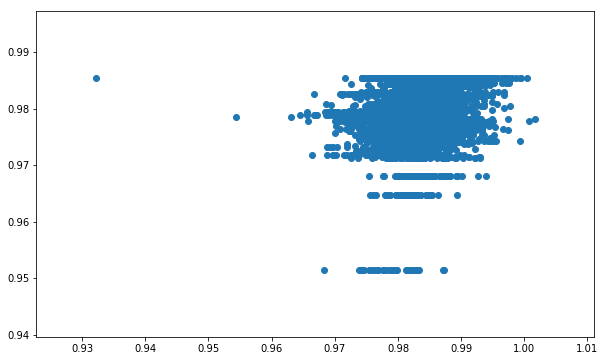

In [10]:
in_sample_prediction = clf.predict(x_train)
plt.scatter(in_sample_prediction, y_train)
plt.show()

1376/1378 [============================>.] - ETA: 0s

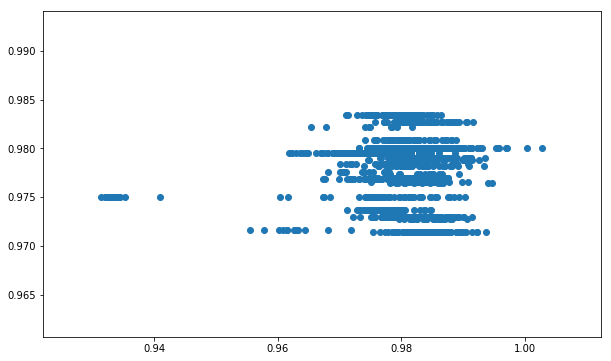

In [11]:
out_sample_prediction = clf.predict(x_test)
plt.scatter(out_sample_prediction, y_test)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
mse_1 = mean_squared_error(y_train, in_sample_prediction)
mse_1

5.8476549152342219e-05

In [13]:
mse_2 = mean_squared_error(y_test, out_sample_prediction)
mse_2

8.5499872177127208e-05